In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder

In [56]:
plt.rcParams['figure.figsize'] = (15, 8)

In [103]:
base_db = pd.read_csv("output/base_db.csv").drop(columns="Unnamed: 0")

## Matrix factorization

We want to give a score to the tuple (chemicals, specie) and compute the pericolosity of the chemicals on new species based on the score (Netflix prize problem)

In [80]:
X_fact = base_db.copy()
X_fact = X_fact[["test_cas", "species", "conc1_mean", "obs_duration_mean"]]

In [81]:
X_fact["score"] = 1/(X_fact.conc1_mean*X_fact.obs_duration_mean)

In [82]:
X_fact = X_fact.groupby(by=["test_cas", "species"]).agg("median")

In [83]:
X_fact = X_fact.drop(columns=["conc1_mean", "obs_duration_mean"]).reset_index()

Standardize the score: apply log(1+x) and scale over (1,5)

In [78]:
X_fact.score = X_fact.score.apply(lambda x: np.log1p(x))

In [63]:
# MinMax scale score
minmax = MinMaxScaler((1, 5))
minmax.fit(X_fact[["score"]])
X_fact[["score"]] = minmax.transform(X_fact[["score"]])

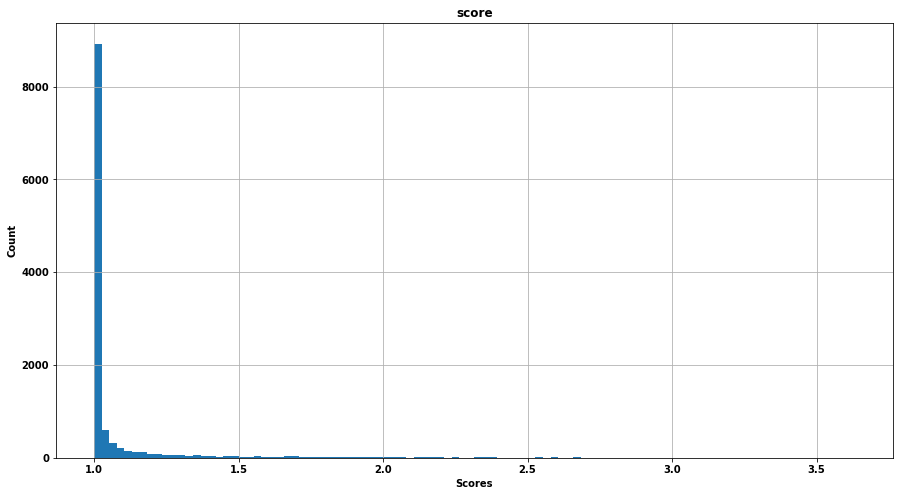

In [72]:
X_fact[["score"]].hist(bins=100);
#plt.yscale("log")
#plt.xscale("log")
plt.xlabel("Scores")
plt.ylabel("Count");

Dropping the outliers:

In [65]:
X_fact[X_fact.score > 4]

,test_cas,species,score
5139,1397940,spathula,4.783209
5869,2642719,niloticus,5.000000
8459,11118722,spathula,4.755218


In [66]:
X_fact = X_fact.drop(index=[5139, 5869, 8459])

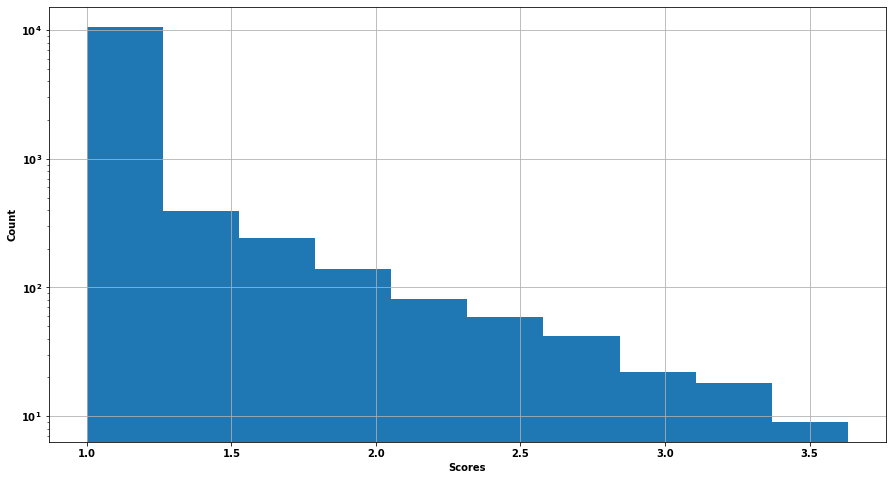

In [73]:
X_fact.score.hist()
plt.yscale('log')
plt.xlabel("Scores")
plt.ylabel("Count");

In [68]:
enc = OrdinalEncoder(dtype=int)
enc.fit(X_fact[["test_cas", "species"]])
X_fact[["test_cas", "species"]] = enc.transform(X_fact[["test_cas", "species"]]) + 1

Output matrix to use with Surprise library:

In [69]:
X_fact.to_csv("output/score_matrix_nomix.csv", header=True, index=False)

Preparing matrix for lab code:

In [70]:
X_fact["id"] = "r" + X_fact.test_cas.astype("str") + '_' + "c"+ X_fact.species.astype("str")

In [71]:
X_fact = X_fact[["id", "score"]].set_index("id")
X_fact.to_csv("output/score_matrix.csv", header=True)

#### Another tentative of scoring

In [126]:
X_fact = base_db.copy()
X_fact = X_fact[["test_cas", "species", "conc1_mean", "obs_duration_mean"]]
X_fact["score"] = 1/(X_fact.conc1_mean*X_fact.obs_duration_mean)
X_fact = X_fact.groupby(by=["test_cas", "species"]).agg("median")
X_fact = X_fact.drop(columns=["conc1_mean", "obs_duration_mean"]).reset_index()

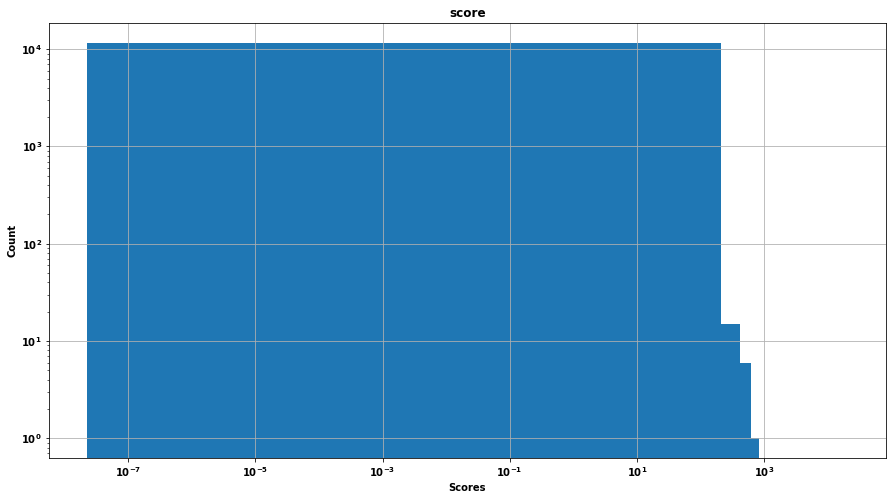

In [127]:
X_fact[["score"]].hist(bins=100);
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Scores")
plt.ylabel("Count");

Giving a score based on the distribution:
- $ < (10^-5)$ -> score 1
- $ >(10^-5)$ and $ <(10^-3)$ -> score 2
- $ >(10^-3)$ and $ <(10^-1)$ -> score 3
- $ >(10^-1)$ and $ <(10^11)$ -> score 4
- $ >(10^1)$ -> score 5

In [128]:
def scores_cat(x):
    if (x <= 10**-5):
        return 1
    elif ((x>10**-5) and (x<=10**-3)):
        return 2
    elif ((x>10**-3) and (x<=10**-1)):
        return 3
    elif ((x>10**-1) and (x<=10**1)):
        return 4
    else:
        return 5

In [129]:
X_fact.score = X_fact.score.apply(lambda x: scores_cat(x))

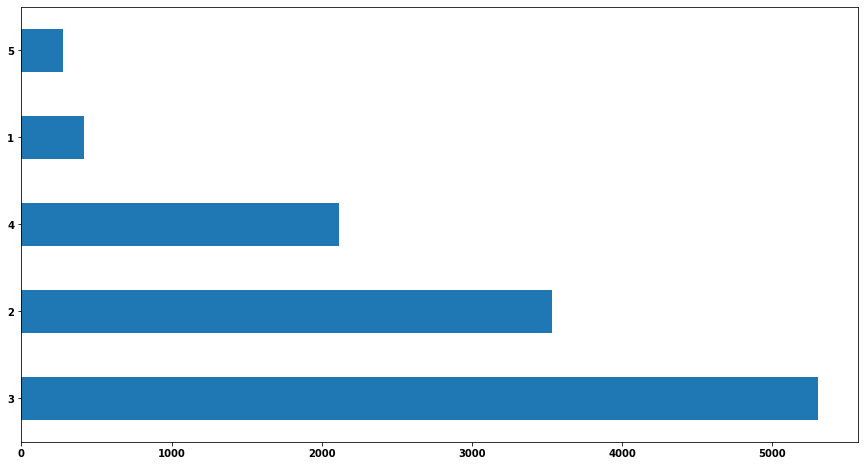

In [130]:
X_fact.score.value_counts().plot(kind="barh");

In [131]:
X_fact.score.value_counts()

3    5306
2    3530
4    2115
1     420
5     279
Name: score, dtype: int64

In [133]:
enc = OrdinalEncoder(dtype=int)
enc.fit(X_fact[["test_cas", "species"]])
X_fact[["test_cas", "species"]] = enc.transform(X_fact[["test_cas", "species"]]) + 1

In [134]:
X_fact.to_csv("output/score_matrix_cat.csv", header=True, index=False)